In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
#from scipy import stats as stats
from pycaret.regression import *



In [2]:
#reading data and preprocessing

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

train_b.to_csv('raw_b.csv')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

class model():
    
    def __init__(self) -> None:


        self.average_measurement_a = {}
        self.average_measurement_b = {}
        self.average_measurement_c = {}
        self.elevation_mapping = {
            6.0 : -1,
            7.0 : 0,
            24.0 : 1
        }


    def add_estimated_flag(self, df, estimated):
        data = df.copy()

        data['estimated'] = 1 if estimated else 0

        return data

    def feature_engineering(self, df):
        data = df.copy()

        #specifying features to drop based on low correlation or qualitative measures
        #NOTE: wind vector v is kept instead of absolute value due to high correlation across locations
        drop = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'precip_5min:mm', 'precip_type_5min:idx', 'rain_water:kgm2', 'snow_density:kgm3', 'snow_drift:idx', 'snow_melt_10min:mm', 'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms', 'wind_speed_10m:ms']

        #dropping specified features
        for feat in drop:
            if feat in data.columns:
                data.drop(columns=feat, axis=1, inplace=True)

        
        return data        

    def preprocessing_X_train(self, df):
        data = df.copy()
        #data = self.feature_engineering(data)
        if 'date_calc' in data.columns:
            data.drop('date_calc', axis=1, inplace=True)
        
        if 'date_forecast' in data.columns:
            data['hour'] = data['date_forecast'].dt.hour
            data['week'] = pd.to_numeric(data['date_forecast'].dt.isocalendar().week)
            data['month'] = data['date_forecast'].dt.month
            data['week_hour'] = data['week'] * 100 + data['hour']
            data.set_index('date_forecast', inplace=True)

        data = data.groupby(pd.Grouper(freq='1H')).mean()
        data.dropna(how='all', inplace=True)

        

        data['loc_flag'] = data['elevation:m'].map(self.elevation_mapping)
        data.drop(columns=['elevation:m'], inplace=True)

        data.rename_axis('time', inplace=True)
        

        return data
    
    def preprocessing_X_train_combo(self, df):
        data = df.copy()
        # Loop through unique loc_flag values (-1, 0, 1)
        for loc_flag in data['loc_flag'].unique():
            # Filter the DataFrame for the current loc_flag value
            filtered_df = data[data['loc_flag'] == loc_flag]
            
            # Group the filtered DataFrame by 'month' and calculate the mean 'pv_measurement'
            avg_measurement_by_month = filtered_df.groupby('week_hour')['pv_measurement'].mean()
            
            # Convert the result to a dictionary
            avg_measurement_dict = avg_measurement_by_month.to_dict()
            
            # Assign the result to the appropriate dictionary based on loc_flag value
            if loc_flag == -1:
                self.average_measurement_a = avg_measurement_dict
            elif loc_flag == 0:
                self.average_measurement_b = avg_measurement_dict
            elif loc_flag == 1:
                self.average_measurement_c = avg_measurement_dict
                
        data['average_measurement'] = data.apply(lambda row: self.average_measurement_a[row['week_hour']]
                                             if row['loc_flag'] == -1
                                             else (self.average_measurement_b[row['week_hour']]
                                                   if row['loc_flag'] == 0
                                                   else self.average_measurement_c[row['week_hour']]), axis=1)
        data.drop(columns='week_hour', axis=1, inplace=True)
        data = data.sample(frac=1, random_state=42).reset_index(drop=True)
        
        return data



    def preprocessing_X_test(self, df):
        data = df.copy()
        if 'date_calc' in data.columns:
            data.drop('date_calc', axis=1, inplace=True)

        #data = self.feature_engineering(data)

        if 'date_forecast' in data.columns:
            data['hour'] = data['date_forecast'].dt.hour
            data['week'] = pd.to_numeric(data['date_forecast'].dt.isocalendar().week)
            data['month'] = data['date_forecast'].dt.month
            data['week_hour'] = data['week'] * 100 + data['hour']
            data.set_index('date_forecast', inplace=True)
            

        data = data.groupby(pd.Grouper(freq='1H')).mean()
        data.dropna(how='all', inplace=True)
        

        data['loc_flag'] = data['elevation:m'].map(self.elevation_mapping)
        data.drop(columns=['elevation:m'], inplace=True)

        data['average_measurement'] = data.apply(lambda row: self.average_measurement_a[row['week_hour']]
                                             if row['loc_flag'] == -1
                                             else (self.average_measurement_b[row['week_hour']]
                                                   if row['loc_flag'] == 0
                                                   else self.average_measurement_c[row['week_hour']]), axis=1)
        
        data.drop(columns='week_hour', axis=1, inplace=True)
        data.rename_axis('time', inplace=True)
        
        return data

    def preprocessing_Y(self, data):
        if 'time' in data.columns:
            data.set_index('time', inplace=True)
        data.dropna(inplace=True)

        # Create a mask to identify sequences of 18 or more consecutive rows with the same 'pv_measurement'
        consecutive_mask = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] != 0)
        consecutive_count = consecutive_mask.groupby((~consecutive_mask).cumsum()).cumsum()
        mask_consecutive = (consecutive_count <= 3) | (~consecutive_mask)

        consecutive_mask_0 = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] == 0)
        consecutive_count_0 = consecutive_mask_0.groupby((~consecutive_mask_0).cumsum()).cumsum()
        mask_consecutive_0 = (consecutive_count_0 <= 96) | (~consecutive_mask_0)

        
         # Filter rows for the specified months (April, May, June, July)
        #mask_time = data.index.month.isin([4, 5, 6, 7])

        # Combine the consecutive rows mask and the time mask
        combined_mask = mask_consecutive & mask_consecutive_0 #& mask_time

        filtered_data = data[combined_mask]

        return filtered_data


model1 = model()

#combining observed and estimated data
observed_a = model1.add_estimated_flag(X_train_observed_a, False)
estimated_a = model1.add_estimated_flag(X_train_estimated_a, True)

x_train_a = pd.concat([observed_a, estimated_a], axis=0)
x_train_a = model1.preprocessing_X_train(x_train_a)
y_train_a = model1.preprocessing_Y(train_a)
x_train_a = x_train_a.merge(y_train_a, how='inner', on='time')
x_train_a = model1.preprocessing_X_train_combo(x_train_a)

x_train_a.to_csv('proc_training_data_a.csv')

observed_b = model1.add_estimated_flag(X_train_observed_b, False)
estimated_b = model1.add_estimated_flag(X_train_estimated_b, True)

x_train_b = pd.concat([observed_b, estimated_b], axis=0)
x_train_b = model1.preprocessing_X_train(x_train_b)
y_train_b = model1.preprocessing_Y(train_b)
x_train_b = x_train_b.merge(y_train_b, how='inner', on='time')
x_train_b = model1.preprocessing_X_train_combo(x_train_b)

x_train_b.to_csv('proc_training_data_b.csv')


observed_c = model1.add_estimated_flag(X_train_observed_c, False)
estimated_c = model1.add_estimated_flag(X_train_estimated_c, True)

x_train_c = pd.concat([observed_c, estimated_c], axis=0)
x_train_c = model1.preprocessing_X_train(x_train_c)
y_train_c = model1.preprocessing_Y(train_c)
x_train_c = x_train_c.merge(y_train_c, how='inner', on='time')
x_train_c = model1.preprocessing_X_train_combo(x_train_c)

x_train_c.to_csv('proc_training_data_c.csv')

x_train = pd.concat([x_train_a, x_train_b, x_train_c], axis=0, ignore_index=True)
x_train = x_train.sample(frac=1, random_state=42).reset_index(drop=True)

checkframe = x_train_a

def corr():
    bad_variables= ['week']

    for col in [col for col in checkframe.columns if col not in bad_variables]:

        corr = checkframe[col].corr(checkframe['pv_measurement'])
        print(f"Correlation between {col} and pv_measurement is: {corr}")


corr()

Correlation between absolute_humidity_2m:gm3 and pv_measurement is: 0.23747745627892308
Correlation between air_density_2m:kgm3 and pv_measurement is: -0.36784721997771014
Correlation between ceiling_height_agl:m and pv_measurement is: 0.17870901587686686
Correlation between clear_sky_energy_1h:J and pv_measurement is: 0.7989488905867347
Correlation between clear_sky_rad:W and pv_measurement is: 0.8116636785055698
Correlation between cloud_base_agl:m and pv_measurement is: 0.17128085311245958
Correlation between dew_or_rime:idx and pv_measurement is: -0.05975444360666951
Correlation between dew_point_2m:K and pv_measurement is: 0.24736842723339145
Correlation between diffuse_rad:W and pv_measurement is: 0.708496447929141
Correlation between diffuse_rad_1h:J and pv_measurement is: 0.7010347730520329
Correlation between direct_rad:W and pv_measurement is: 0.8674126262451317
Correlation between direct_rad_1h:J and pv_measurement is: 0.8531491694260633
Correlation between effective_cloud_c

Checkpoint 2
Checkpoint 3


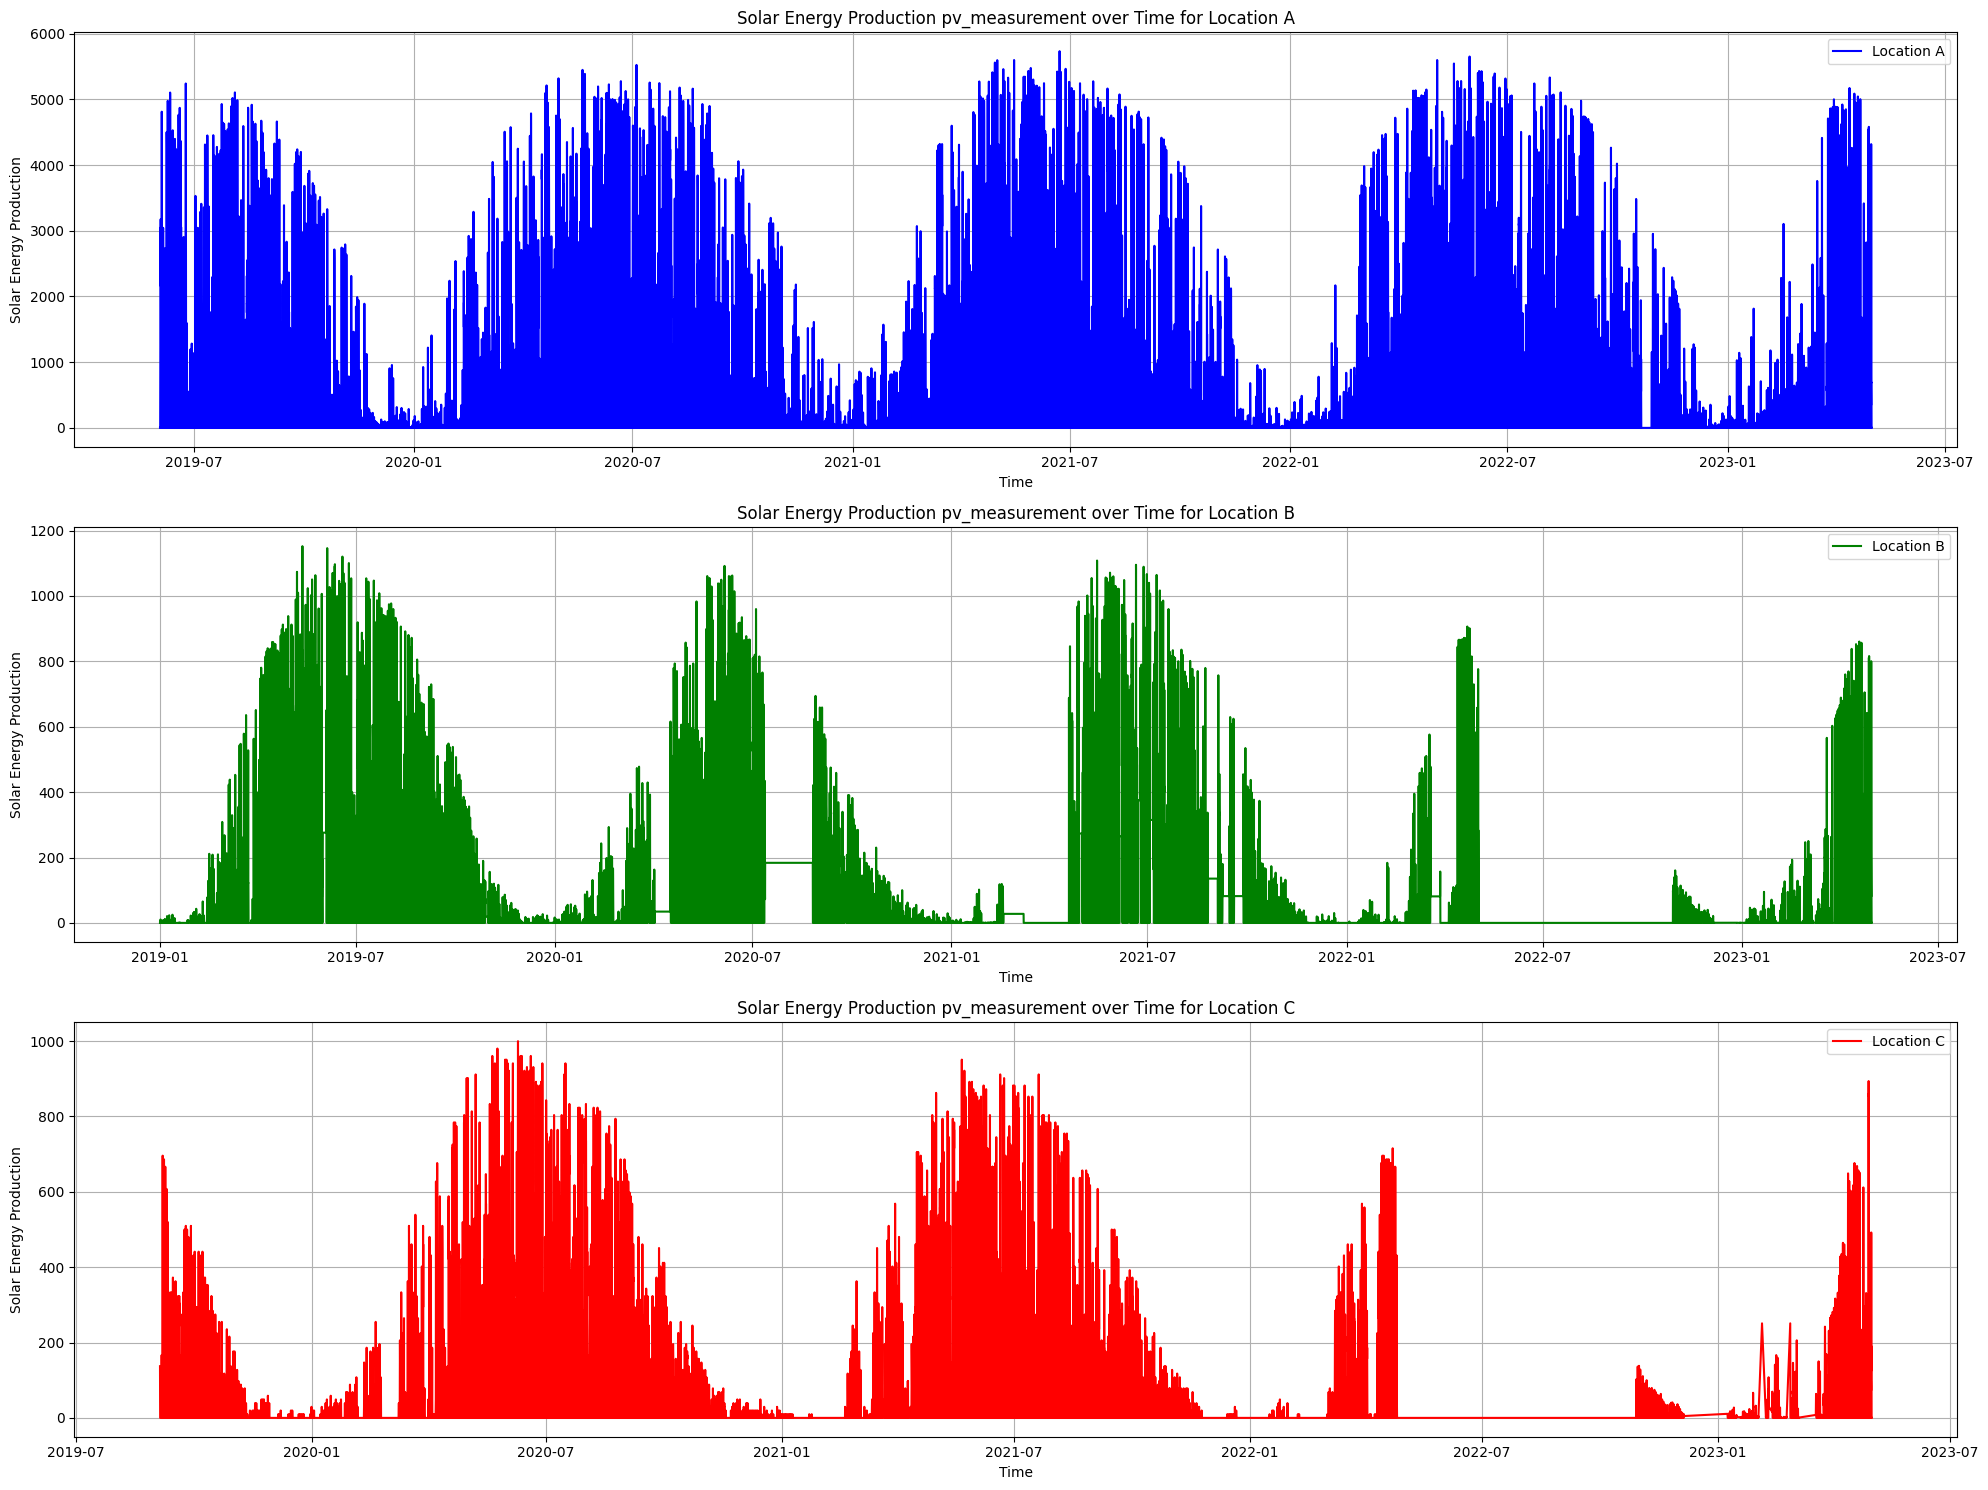

In [69]:
#exploratory data analysis and vizualization 
%matplotlib inline

data_a = train_a
data_b = train_b
data_c = train_c

columns = data_a.columns.to_list()

el = 'pv_measurement'


# Plotting the pv_measurement over time for locations A, B, and C
print('Checkpoint 2')
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(data_a[el], label='Location A', color='blue')
plt.title(f'Solar Energy Production {el} over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

print('Checkpoint 3')

# Location B
plt.subplot(3, 1, 2)
plt.plot(data_b[el], label='Location B', color='green')
plt.title(f'Solar Energy Production {el} over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(data_c[el], label='Location C', color='red')
plt.title(f'Solar Energy Production {el} over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)



plt.tight_layout()

plt.show()




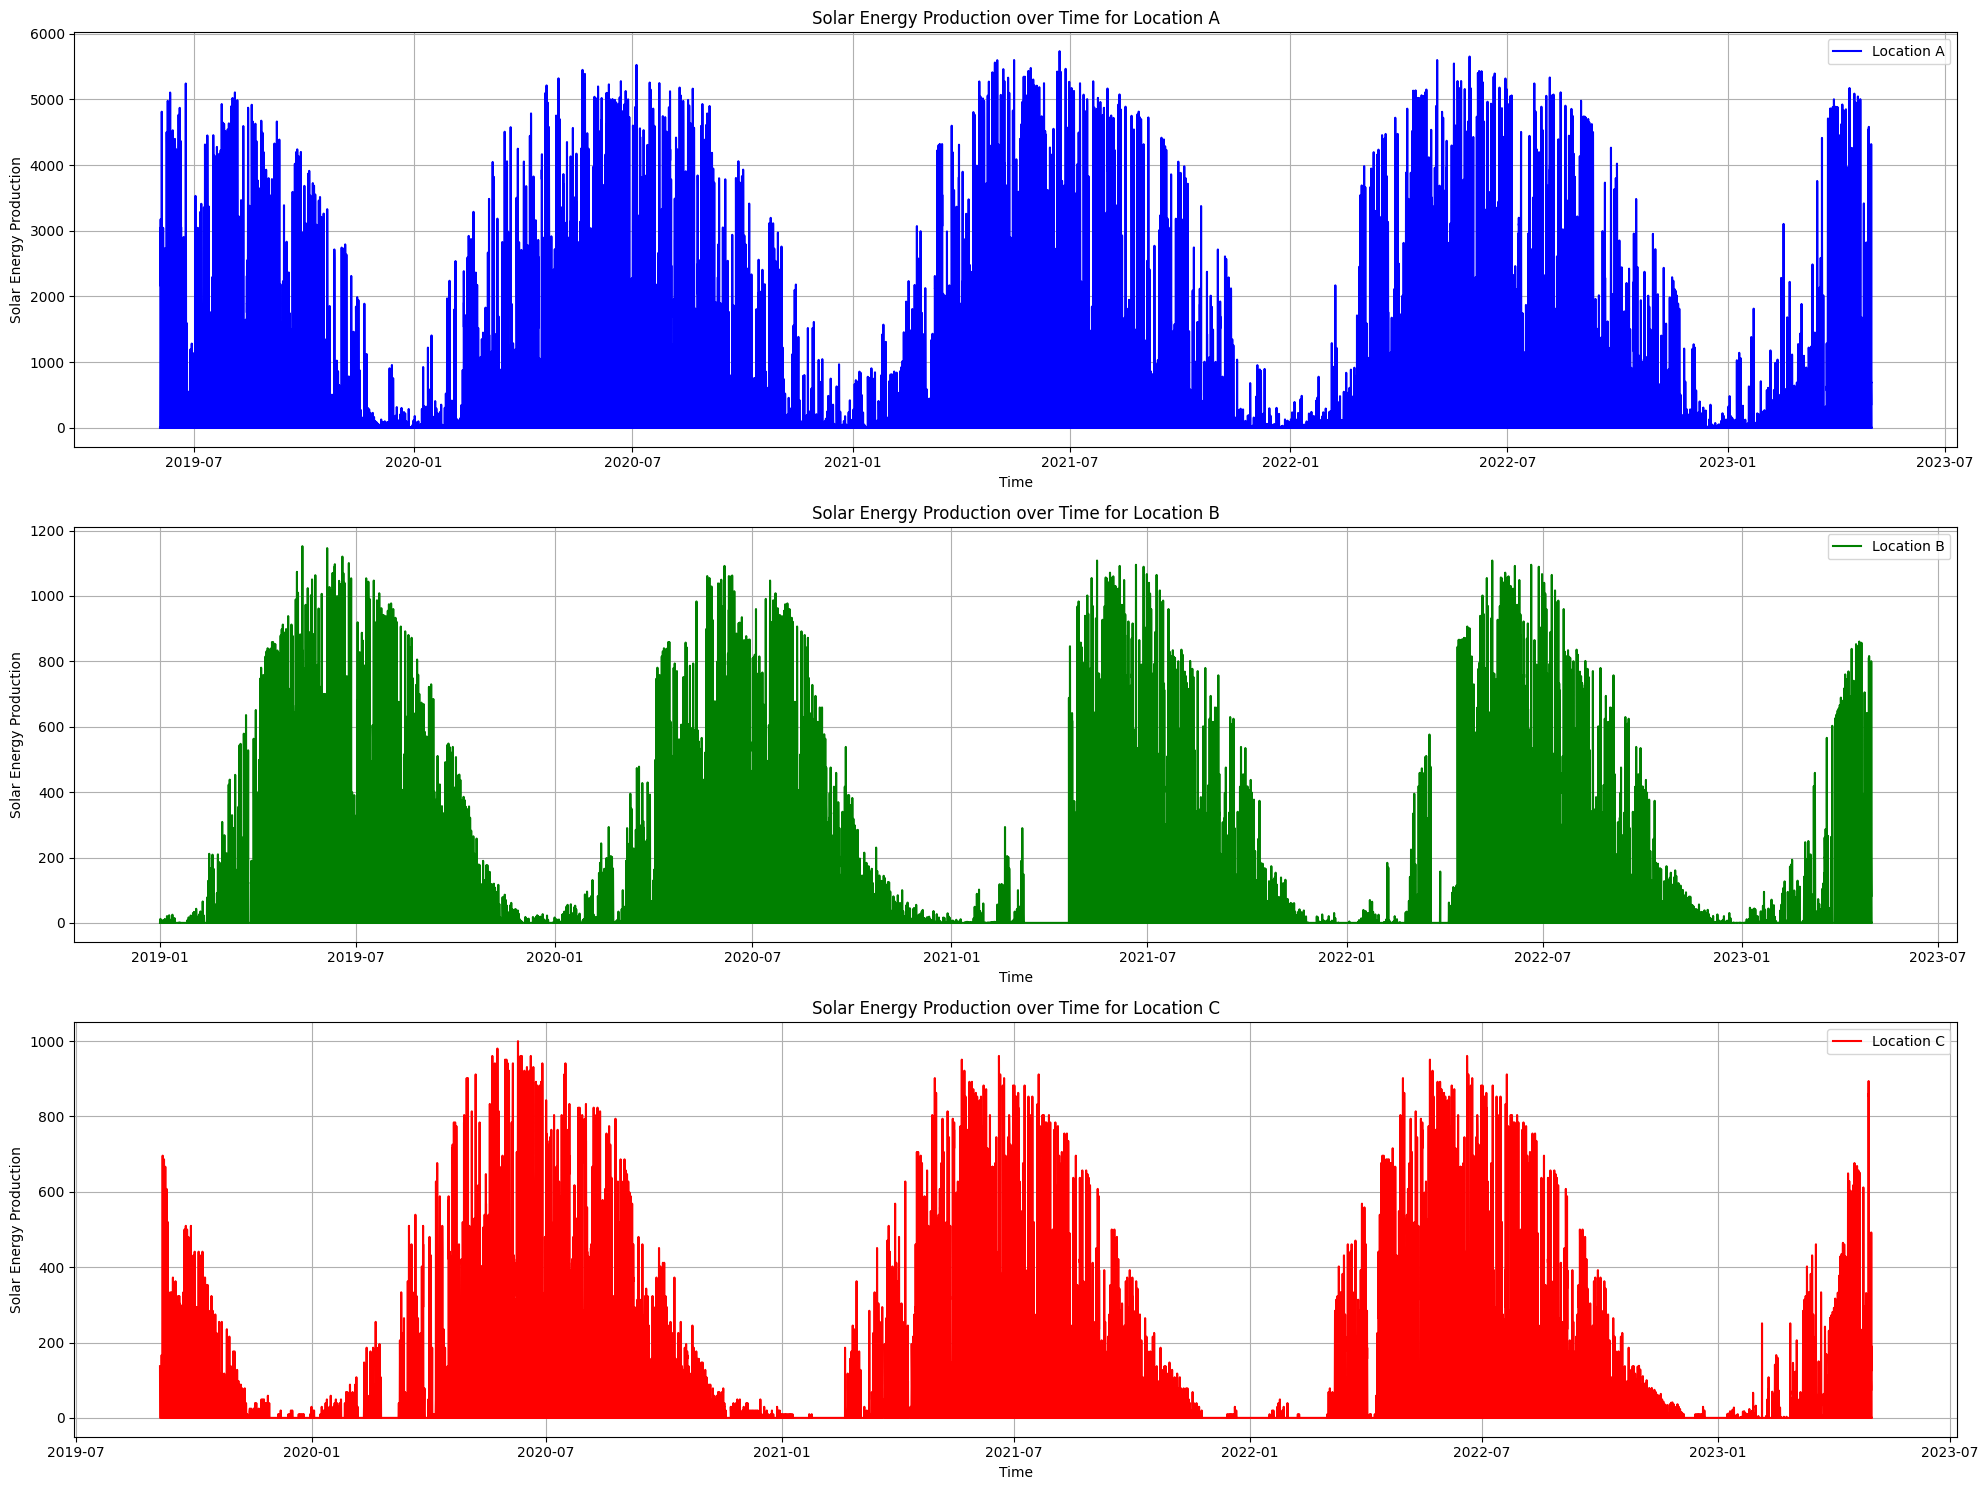

In [4]:
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(x_train_a['pv_measurement'], label='Location A', color='blue')
plt.title(f'Solar Energy Production over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location B
plt.subplot(3, 1, 2)
plt.plot(x_train_b['pv_measurement'], label='Location B', color='green')
plt.title(f'Solar Energy Production over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(x_train_c['pv_measurement'], label='Location C', color='red')
plt.title(f'Solar Energy Production over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
# manual ensemble

from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()

# Identify predictors and response
data = h2o.H2OFrame(x_train)
x = data.columns
y = 'pv_measurement'
x.remove(y)


# Number of CV folds (to generate level-one data for stacking)
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 2. Generate a random grid of models and stack them together

# Specify GBM hyperparameters for the grid
hyper_params_gbm = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}



hyper_params_forest = {"max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "ntrees": [20, 30, 40, 50, 60, 70]}

hyper_params_nn = {
    "activation": ["Rectifier", "Tanh", "Maxout"],
    "hidden": [[32, 32], [64, 64], [100, 100]],
    "epochs": [10, 20, 30],
}


hyper_params_xgb = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 5, "seed": 1}

# Train the grid
grid_gradient = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution="poisson",
                                                        ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params_gbm,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid")
grid_gradient.train(x=x, y=y, training_frame=data)

# Train and cross-validate a RF
grid_forest = H2OGridSearch(model=H2ORandomForestEstimator(
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1),
                    hyper_params=hyper_params_forest,
                    search_criteria=search_criteria,
                    grid_id="forest_grid")
grid_forest.train(x=x, y=y, training_frame=data)

grid_nn = H2OGridSearch(model=H2ODeepLearningEstimator(
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1),
                    hyper_params=hyper_params_nn,
                    search_criteria=search_criteria,
                    grid_id="nn_grid")
grid_nn.train(x=x, y=y, training_frame=data)


grid_xgb = H2OGridSearch(model=H2OXGBoostEstimator(booster='dart', normalize_type='tree', seed=1234),
                     hyper_params=hyper_params_xgb,
                     search_criteria=search_criteria,
                     grid_id="xgb_grid")
grid_xgb.train(x=x, y=y, training_frame=data)

model_ids = []

if grid_forest is not None:
    model_ids += grid_forest.model_ids
if grid_gradient is not None:
    model_ids += grid_gradient.model_ids
if grid_nn is not None:
    model_ids += grid_nn.model_ids
if grid_xgb is not None:
    model_ids += grid_xgb.model_ids

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="ensemble_gbm_forest_xgb",
                                       base_models=model_ids)
ensemble.train(x=x, y=y, training_frame=data)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_z59m9ze
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_z59m9ze/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_z59m9ze/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_olelasson_2az9pf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
xgboost Grid Build progress: |███████████████████████████████████████████████████| (done) 100%
stackedensemble Model Build progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_bed6377b266d1390201b0ac1e6b14f73 failed with an exception: water.exceptions.H2OIllegalArgumentException: Base model does not use cross-validation: 0
stacktrace: 
water.exceptions.H2OIllegalArgumentException: Base model does not use cross-validation: 0
	at hex.ensemble.StackedEnsemble.checkAndInheritModelProperties(StackedEnsemble.java:483)
	at hex.ensemble.StackedEnsemble$StackedEnsembleDriver.computeImpl(StackedEnsemble.java:767)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [18]:

best_gradient = grid_gradient.get_grid(sort_by='mae', decreasing=False).models[0]
best_forest = grid_forest.get_grid(sort_by='mae', decreasing=False).models[0]
best_nn = grid_nn.get_grid(sort_by='mae', decreasing=False).models[0]
best_xgb = grid_xgb.get_grid(sort_by='mae', decreasing=False).models[0]


### AutoML H20

In [7]:
#AutoML H2O

def train(model):
    if model.lower() == 'a':
        automl_df=x_train_a
    elif model.lower() == 'b':
        automl_df=x_train_b
    elif model.lower() == 'c':
        automl_df=x_train_c
    elif model.lower() == 's':
        automl_df=x_train
    else:
        return

    h2o.init()
    train_df = h2o.H2OFrame(automl_df)
    train_df.describe()

    test = h2o.H2OFrame(automl_df)
    x = test.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    from h2o.automl import H2OAutoML
    # callh20automl  function
    aml = H2OAutoML(max_models=20,
                    sort_metric='MAE',
                    stopping_metric='MAE',
                    stopping_tolerance=0.004
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = test)

    leaderboard = aml.leaderboard

    # Obtain the leader model
    best_model_1 = h2o.get_model(leaderboard[0, 'model_id'])
    best_model_2 = h2o.get_model(leaderboard[1, 'model_id'])
    best_model_3 = h2o.get_model(leaderboard[2, 'model_id'])


    # Save the leader model
    model_path_1 = h2o.save_model(model=best_model_1, path="/tmp/mymodel", force=True)
    model_path_2 = h2o.save_model(model=best_model_2, path="/tmp/mymodel", force=True)
    model_path_3 = h2o.save_model(model=best_model_3, path="/tmp/mymodel", force=True)

    # Load the saved model
    loaded_model_1 = h2o.load_model(model_path_1)
    loaded_model_2 = h2o.load_model(model_path_2)
    loaded_model_3 = h2o.load_model(model_path_3)

    # Download the model to local machine
    my_local_model_1 = h2o.download_model(best_model_1, path=f"./models/{model.upper()}")
    my_local_model_2 = h2o.download_model(best_model_2, path=f"./models/{model.upper()}")
    my_local_model_3 = h2o.download_model(best_model_3, path=f"./models/{model.upper()}")

    h2o.cluster().shutdown()

    return my_local_model_1, my_local_model_2, my_local_model_3 

 

### Pycaret

In [6]:
def plot_data(training, validation, prediction):
    #print("train", training)
    #print("validation", validation)
    #print("prediction", prediction)
    target = "consumption"

    plot_df = validation.copy()[["time", "consumption"]]
    plot_df["prediction"] = prediction["prediction_label"]
    print(plot_df)

    locations = ["oslo", "bergen", "trondheim", "tromsø", "stavanger", "helsingfors"]

    plt.figure(figsize=(12, 6))
    fig, axs = plt.subplots(len(locations), 1, figsize=(20, 10), sharex=True)

    for i, location in enumerate(locations):
      location_validation = validation[validation["location"] == location]
      location_prediction = prediction[prediction["location"] == location]

      axs[i].plot(location_prediction["time"], location_prediction =["prediction_label"], label=f"{location} Predictions")
      axs[i].plot(location_validation["time"], location_validation[target], label=f"{location} Validation")

    plt.xlabel('Date Forecast')
    plt.ylabel(target)
    plt.title(f"{target} Over Time")
    plt.legend()
    plt.show()



def pipeline(plot=False):
    print("Running pipeline...")

    # Initialize PyCaret setup
    reg = setup(
        data=x_train,
        target='pv_measurement',  # Assuming 'consumption' is the target variable
        verbose=False  # Disable setup display for simplicity
    )

    # Create model using AutoML
    best_model = create_model('et')

    # Display the best model
    print("Best model:", best_model)
    evaluate_model(best_model)

    #plot_data(train_test_data, validation_data, validation_prediction)

    # print(f'Validation Predictions: {predicted_consumption},\n Actual Values: {validation_y}')

    return best_model

best_model = pipeline(plot=False)

Running pipeline...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,85.4407,61567.8828,248.1288,0.9054,0.6484,1.0125
1,81.4244,63417.8111,251.8289,0.8938,0.6778,1.1629
2,85.9777,66763.0921,258.3855,0.8939,0.6415,0.9410
3,89.7125,74082.5750,272.1811,0.8789,0.6599,1.1655
4,84.7141,67053.6250,258.9471,0.8904,0.6521,1.1394
5,82.6230,60601.8273,246.1744,0.8968,0.6597,1.1931
6,88.8352,72141.8117,268.5923,0.8895,0.6727,1.1571
7,89.6476,71121.6119,266.6864,0.8970,0.6469,3.8859
8,87.8341,75287.9367,274.3865,0.8839,0.6490,1.1149


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Best model: ExtraTreesRegressor(n_jobs=-1, random_state=1809)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [22]:
x_test_a = model1.add_estimated_flag(X_test_estimated_a, True)
x_test_a = model1.preprocessing_X_test(x_test_a)

x_test_b = model1.add_estimated_flag(X_test_estimated_b, True)
x_test_b = model1.preprocessing_X_test(x_test_b)

x_test_c = model1.add_estimated_flag(X_test_estimated_c, True)
x_test_c = model1.preprocessing_X_test(x_test_c)

x_test = pd.concat([x_test_a, x_test_b, x_test_c], axis=0, ignore_index=True)

predictions = predict_model(best_model, data=x_test)

predictions = predictions['prediction_label'].to_frame()

predictions.index.name='id'
predictions.rename(columns={'prediction_label':'prediction'},inplace=True)
predictions['prediction'] = predictions['prediction'].apply(lambda x: 0.0 if x < 5 else x)

predictions.to_csv('pycarrot.csv')

### Train with H2O

In [6]:
my_local_model_all1, my_local_model_all2, my_local_model_all3 = train('s')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,10 mins 03 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_olelasson_z54uyo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.571 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:85799
Cols:37

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_v_10m:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,0.699999988079071,1.1392500400543213,27.849998474121097,0.0,0.0,27.5,-1.0,251.0500030517578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.4000244140624,932.2999877929688,938.0499877929688,0.0,19.575000762939453,943.8499755859376,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,259.0,0.0,159.6750030517578,-8.399999618530273,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
mean,6.0707464552325545,1.254501922880667,2880.130424568151,521457.78099647624,144.83199482741284,1739.4779392580572,0.01233697362440121,275.4310029862074,39.77909824432435,143216.4047868733,51.29345592085724,184678.07989603083,67.05022816900603,0.4865033391997574,0.5607786804042012,1009.5855108415008,995.9289756161963,1002.0556157125604,0.6590945115661913,73.64546934647639,1008.2095099258319,0.14165462329338513,0.09024435101133482,179.65207838720082,-1.0127744724801828,0.05678533652665805,279.59666073650305,73.7154384295296,33021.993665999806,0.6622344076249925,0.1273324863926153,11.50300120048018,26.067483304001208,6.390692199209778,-0.12329980535903677,306.56759134006876,306.5675913400687
maxs,17.350000381469727,1.4262499809265137,12294.9013671875,2990595.5,835.6500244140625,11673.625,1.0,293.625,334.75,1198315.125,683.4000244140625,2441810.5,100.0,1.0,1.0,1043.949951171875,1030.875,1037.25,96.7750015258789,100.0,1043.7249755859375,18.200000762939453,5.650000095367432,348.4875183105469,49.943748474121094,1.375,303.25,100.0,75489.328125,8.824999809265137,1.0,23.0,53.0,12.0,1.0,5733.42,3812.7676190476186
sigma,2.6751689098610067,0.03584455404806471,2532.293404700944,824683.5338878006,229.64951914047512,1801.1203677810122,0.2290949885558902,6.651964017305713,60.87236057250887,216576.77655366503,114.39082498189258,406554.5985333287,34.25938242508671,0.4860851463626131,0.48364672788841206,12.970011587784269,12.858879489859117,12.917664672526653,5.000589288769973,14.306382200507565,12.97850269744141,1.0817596657409727,0.23771620481902525,97.32796100977235,24.01777535860242,0.10533005857101763,6.438070194907278,33.98718229316546,17912.78951348285,1.8735827045050553,0.3333469955230389,6.917666554018569,15.589431201281513,3.5681151934311077,0.8096153099065286,794.5587444035265,680.4258083529015
zeros,0,0,0,37721,41302,0,80145,0,41322,37729,47651,43270,3166,41291,35077,0,0,0,82745,0,0,82731,56646,0,0,55251,0,3159,0,507,74874,3568,0,0,28256,45212,38037
missing,0,0,15048,0,0,6220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,13.350000381469728,1.1779999732971191,2830.35009765625,481001.46875,86.2750015258789,1955.25,0.0,289.1499938964844,25.299999237060547,126286.1484375,4.199999809265137,20895.42578125,99.375,1.0,0.0,1004.75,992.4000244140624,998.1500244140624,0.0,69.69999694824219,1003.9500122070312,0.0,0.375,307.20025634765625,8.231499671936035,0.30000001192092896,294.45001220703125,100.0,3969.14990234375,0.45000001788139343,0.0,19.0,26.0,6.0,-1.0,45.76,218.85285714285715
1,8.774999618530273,1.209750056266785,3159.14990234375,1907178.125,514.1500244140625,252.9750061035156,0.0,282.25,141.0500030517578,540909.5,104.1750030517578,280338.53125,97.9749984741211,1.0,0.0,1000.5250244140624,985.2999877929688,991.2249755859376,0.0,80.17500305175781,997.2000122070312,0.0,0.22500000894069672,199.812255859375,30.43774

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
H2O session _sid_99d3 closed.


In [8]:
my_local_model_A1, my_local_model_A2, my_local_model_A3 = train('a')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_1ce6tbl
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_1ce6tbl/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_1ce6tbl/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 5 days
H2O_cluster_name:,H2O_from_python_olelasson_66915f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:34061
Cols:51

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,0.699999988079071,1.1449999809265137,27.849998474121097,0.0,0.0,27.799999237060547,-1.0,251.0749969482422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.4000244140624,0.0,0.0,932.4000244140624,938.2000122070312,0.0,0.0,21.700000762939453,944.0,,0.0,0.0,0.0,0.0,6.982999801635742,-49.89399719238281,0.0,259.0,0.0,159.6750030517578,0.02500000037252903,-7.224999904632568,-8.399999618530273,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
mean,6.322320250351404,1.2532797771004047,2974.14913451821,552671.1678821977,153.51968819845223,1728.9234730646938,0.0206688000939491,275.97182254114244,42.06996638320769,151451.71881457852,52.627699588204145,189459.8762303027,67.70161258036268,0.08820278320963193,0.007402894869658934,0.1735951675916984,0.02228942194988067,0.044404891222861495,0.4991852852235699,0.5353483456152212,1009.6038430638005,0.006014650169552621,0.08907548222307042,996.707565888651,1002.8290874581662,0.23188544087143012,0.010782860349083405,74.02536330787679,1008.9778176316063,,0.07350855843764995,0.0,0.00012727165757659992,0.08968835406596855,179.63674567712494,-0.04687209569276738,0.0556648376432158,279.9364118813761,74.31900637064275,32577.394217938392,3.0613135245948064,0.657206189457783,0.5701616212857097,1.6881477601014875e-05,0.12900384604092657,11.500954170458915,26.71712515780512,6.541499075188636,-1.0,631.0111649687311,631.0111649687324
maxs,17.350000381469727,1.4262499809265137,12294.9013671875,2988627.5,835.0999755859375,11673.625,1.0,293.625,332.2749938964844,1191085.25,683.4000244140625,2441749.5,100.0,15.0,3.549999952316284,15.0,7.875,14.225000381469728,1.0,1.0,1043.949951171875,0.6225000023841858,3.75,1030.875,1037.25,91.875,1.100000023841858,100.0,1043.7249755859375,,6.300000190734863,0.0,0.13249999284744263,5.650000095367432,348.48651123046875,49.90550231933594,1.2999999523162842,303.25,100.0,69395.5234375,13.274999618530272,11.199999809265137,8.25,0.10000000149011612,1.0,23.0,53.0,12.0,-1.0,5733.42,3812.7676190476186
sigma,2.799442323741873,0.037206445927163656,2564.6419017061953,848338.9524549855,236.2447308807289,1807.1378242461658,0.1852969847046359,6.892324036977622,62.83852337735892,223524.79904018884,115.25055669696073,409345.4349368959,33.80825328570261,0.5945263496675197,0.08363566233487287,0.9281759804668744,0.21411340340938514,0.36671326776706253,0.48615716909371454,0.48665592243719474,12.739137877864252,0.030217786318958405,0.32368891729126803,12.603231746387431,12.659498234018814,2.80325699589278,0.0439449797955417,13.88120056916824,12.717940639972694,,0.4684876086566733,0.0,0.0026485422313329006,0.23754756124089974,97.65791732299918,24.155150298492867,0.10391866683948683,6.6649301993502705,33.49235436406497,17701.938312145758,1.7749815402052527,2.8897352083282972,1.8371422374293835,0.0011572652695004493,0.335209117844851,6.923088968291048,15.219132869880672,3.479107136427629,0.0,1166.2060656312117,973.57323228666

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:20:09.82: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

██
12:20:39.575: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]


12:20:43.156: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

███
12:21:03.898: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

█
12:21:23.257: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

███
12:22:32.485: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

█
12:22:44.943: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

█
12:22:58.897: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

█
12:23:13.322: _train param, Dropping bad and constant columns: [snow_drift:idx, loc_flag]

█
12:23:29.231: _train param, Dropping bad and c

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_a52cae37d7c5bf4ae4369ec123a841eb> was cancelled by the user.

In [11]:
my_local_model_B1, my_local_model_B2, my_local_model_B3 = train('b')


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpju2xjicm
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpju2xjicm/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpju2xjicm/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_olelasson_a6ziks
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:28256
Cols:37

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_v_10m:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,0.699999988079071,1.1514999866485596,27.849998474121097,0.0,0.0,27.975000381469727,-1.0,251.0500030517578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.5,932.2999877929688,938.0499877929688,0.0,19.575000762939453,943.8499755859376,0.0,0.0,6.983749866485596,-49.89324951171875,0.0,259.0249938964844,0.0,270.0,-7.599999904632568,0.0,0.0,1.0,1.0,0.0,0.0,0.0
mean,5.81020668169667,1.2573785831685582,2693.3370085841652,492406.7818484832,136.74396058603534,1749.5245142587908,0.008785744620611552,274.77162901974515,37.86908443523278,136350.55352306383,50.23902179190022,180909.49111098875,66.4125221271007,0.47234215741789354,0.5634909399773496,1009.2492646728207,996.1894349933057,1002.3299059927278,0.053448824799568986,72.88032716823186,1008.4978005829381,0.3167822768386069,0.08822285614515894,179.6164424531289,-2.0742758973106064,0.05385493445543721,279.0154904660396,73.15029640836705,33885.9379322693,0.5888191882457228,0.12744195922989807,11.5039637599094,24.50491930917328,6.034966024915067,0.0,98.54980391373749,98.54980391373755
maxs,17.350000381469727,1.4254999160766602,12285.775390625,2988610.25,835.0999755859375,11259.0,1.0,293.6000061035156,332.2749938964844,1129488.75,683.4000244140625,2441810.5,100.0,1.0,1.0,1042.14990234375,1029.0,1035.2249755859375,73.0999984741211,100.0,1041.4749755859375,18.200000762939453,3.325000047683716,348.4875183105469,49.90550231933594,1.2999999523162842,303.25,100.0,68500.0,7.800000190734863,1.0,23.0,53.0,12.0,0.0,1152.3,836.6660714285714
sigma,2.6058076510660473,0.03524968498541301,2385.675515883048,809106.0734083375,225.2733685898627,1698.4312648151194,0.11149733607170144,6.651210972628051,59.48611376699649,211734.59384580527,114.19418979349417,406124.14228740777,34.3417347616049,0.48563729420852286,0.4835635816745062,13.285913517542685,13.16158777326913,13.222065700724398,1.1160700733196705,14.434331950619583,13.284666460338585,1.7782218482958052,0.23181815360706798,97.02648379834557,24.093696964473054,0.10217758007857526,6.509573646903718,34.159311564437886,17788.592746993807,1.8631270284726638,0.3334733000737576,6.918213099119648,16.01010267253354,3.667046350309341,0.0,205.72010714963398,182.37523564203428
zeros,0,0,0,12831,14009,0,27777,0,14013,12832,15790,14377,1058,14005,11494,0,0,0,28108,0,0,26772,18761,0,0,18566,0,1058,0,176,24655,1176,0,0,28256,15841,12414
missing,0,0,4322,0,0,1909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,5.800000190734863,1.2667499780654907,410.375,0.0,0.0,410.375,0.0,275.79998779296875,0.0,0.0,0.0,0.0,100.0,0.0,1.0,1009.7999877929688,996.75,1002.9000244140624,0.0,90.05000305175781,1009.1500244140624,0.0,1.225000023841858,60.696998596191406,-34.77825164794922,0.20000000298023224,277.29998779296875,100.0,1389.9000244140625,-0.3500000238418579,0.0,2.0,47.0,11.0,0.0,0.0,0.0
1,9.149999618530272,1.2059999704360962,641.9000244140625,0.0,0.0,641.9000244140625,0.0,282.8999938964844,0.0,0.0,0.0,0.0,97.9000015258789,0.0,1.0,994.625,982.0499877929688,987.9500122070312,0.0,83.5250015258789,993.875,0.0,0.0,180.67950439453125,-3.2925000190734863,0.02500000037252903,286.1000061035156,97.9000015258789,3902.925048828125,1.7000000476837158,0.0,23.0,26.0,6.0,0.0,0.0,0.0
2,4.625,1.27400004863739,3267.5749511

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:24:13.586: _train param, Dropping bad and constant columns: [loc_flag]

████████████████
10:24:44.275: _train param, Dropping bad and constant columns: [loc_flag]

█
10:24:48.21: _train param, Dropping bad and constant columns: [loc_flag]

█████████████████████
10:25:27.104: _train param, Dropping unused columns: [loc_flag]
10:25:27.876: _train param, Dropping bad and constant columns: [loc_flag]

████
10:25:35.80: _train param, Dropping bad and constant columns: [loc_flag]

████
10:25:42.547: _train param, Dropping bad and constant columns: [loc_flag]

████
10:25:48.869: _train param, Dropping bad and constant columns: [loc_flag]

███
10:25:55.533: _train param, Dropping bad and constant columns: [loc_flag]

███
10:26:02.136: _train param, Dropping unused columns: [loc_flag]

█
10:26:02.763: _train param, Dropping unused columns: [loc_flag]
10:26:03.584: _train param, D

In [12]:
my_local_model_C1, my_local_model_C2, my_local_model_C3 = train('c')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpfm2rlog9
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpfm2rlog9/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpfm2rlog9/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_olelasson_gnkqo5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:23482
Cols:37

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_v_10m:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,1.100000023841858,1.1392500400543213,28.399999618530273,0.0,0.0,27.5,-1.0,255.0500030517578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.4500122070312,935.7000122070312,941.5499877929688,0.0,21.325000762939453,947.4000244140624,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,264.6000061035156,0.0,292.625,-7.875,0.0,0.0,1.0,1.0,1.0,0.0,0.0
mean,6.019343542596808,1.252813165293026,2977.805315973944,511139.48873905453,141.96273205649916,1742.7220350067782,0.004524742355847041,275.4399637193535,38.754487500400266,139532.6666986594,50.626920582909555,182276.77165007745,66.87273977299435,0.4851481986202187,0.5944020952218722,1009.9635262540894,994.4862065407448,1000.603628348474,2.0075440764334087,74.01512649532263,1006.7481663616753,0.02976961079348739,0.09348330727122633,179.71719960307058,-1.1365210271070247,0.061936803752334624,279.8031714007034,73.51999193041205,32627.3038019639,0.8841282673593842,0.12477642449535814,11.504812196576095,27.005408397921794,6.599991482837916,1.0,86.26600034068657,86.26600034068635
maxs,15.925000190734863,1.371749997138977,12260.224609375,2990595.5,835.6500244140625,11652.7001953125,1.0,292.07501220703125,334.75,1198315.125,682.3250122070312,2437657.75,100.0,1.0,1.0,1043.9000244140625,1028.300048828125,1034.64990234375,96.7750015258789,100.0,1041.0999755859375,6.599999904632568,3.549999952316284,348.47698974609375,49.943748474121094,1.375,302.8999938964844,100.0,75489.328125,8.824999809265137,1.0,23.0,53.0,12.0,1.0,999.6,778.4
sigma,2.536711163978521,0.03430080098145295,2648.8451810379097,806748.9054222124,224.68981219296958,1910.9596875671398,0.3561386657003034,6.212462050259785,59.50339576725114,211662.34900949782,113.35659752194852,402942.56521150086,34.790987579842536,0.4860499309102738,0.4771980853547916,12.906788603281017,12.739159876512822,12.799100094382608,8.714803465539623,14.717299768521864,12.860809499476165,0.3104134390938312,0.24483993052395167,97.21479419682504,23.66819525769018,0.11078007644847378,5.950624659666227,34.47601414163358,18324.377082131552,1.9198292925156482,0.33047226701131877,6.9094293273010265,15.465237078802195,3.542881434391117,0.0,172.65645494926548,153.27035987364755
zeros,0,0,0,10357,11335,0,19848,0,11343,10361,13683,12494,1017,11334,8764,0,0,0,21174,0,0,23038,15348,0,0,14606,0,1010,0,119,20552,972,0,0,0,13348,11210
missing,0,0,4599,0,0,1948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,3.0999999046325684,1.2339999675750732,3676.39990234375,2649232.5,740.4500122070312,1608.25,0.0,267.70001220703125,158.4250030517578,501045.21875,472.4750061035156,1852551.5,72.7750015258789,1.0,0.0,1002.5,986.9000244140624,992.9000244140624,0.0,37.150001525878906,999.0,0.0,0.0,181.8767547607422,43.045501708984375,0.0,278.82501220703125,92.8000030517578,54780.97265625,-2.299999952316284,0.0,11.0,18.0,5.0,1.0,793.8000000000001,518.7
1,4.900000095367432,1.2787500619888306,919.0250244140624,15791.2998046875,0.0,625.2000122070312,0.0,273.3500061035156,0.0,10958.125,0.0,0.0,100.0,0.0,1.0,1016.5499877929688,1000.7249755859376,1006.9500122070312,0.0,85.5999984741211,1013.25,0.550000011920929,0.8500000238418579,265.47100830078125,-4.504499912261963,0.10000000149011612,274.70001220703125,100.0,5306.5751953125,

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:26:49.114: _train param, Dropping bad and constant columns: [loc_flag]

█████████████
10:27:14.68: _train param, Dropping bad and constant columns: [loc_flag]

██
10:27:18.542: _train param, Dropping bad and constant columns: [loc_flag]

█████████████
10:27:42.174: _train param, Dropping unused columns: [loc_flag]
10:27:43.67: _train param, Dropping bad and constant columns: [loc_flag]

█████
10:27:53.50: _train param, Dropping bad and constant columns: [loc_flag]

█████
10:28:03.42: _train param, Dropping bad and constant columns: [loc_flag]

█████
10:28:10.717: _train param, Dropping bad and constant columns: [loc_flag]

████
10:28:18.261: _train param, Dropping bad and constant columns: [loc_flag]

████
10:28:27.819: _train param, Dropping unused columns: [loc_flag]

█
10:28:28.340: _train param, Dropping unused columns: [loc_flag]
10:28:28.803: _train param, Dropping

In [40]:
models = [best_forest, best_gradient, best_nn, best_xgb]

x_test_a = preprocessing_X_test(X_test_estimated_a)
est_test_a = h2o.H2OFrame(x_test_a)
x_test_b = preprocessing_X_test(X_test_estimated_b)
est_test_b = h2o.H2OFrame(x_test_b)
x_test_c = preprocessing_X_test(X_test_estimated_c)
est_test_c = h2o.H2OFrame(x_test_c)

master_a_df = pd.DataFrame()
master_b_df = pd.DataFrame()
master_c_df = pd.DataFrame()

count = 0

for model in models:

    preds_a_df = model.predict(est_test_a).as_data_frame()
    master_a_df[f'prediction_{count}'] = preds_a_df
    
    preds_b_df = model.predict(est_test_b).as_data_frame()
    master_b_df[f'prediction_{count}'] = preds_b_df

    
    preds_c_df = model.predict(est_test_c).as_data_frame()
    master_c_df[f'prediction_{count}'] = preds_c_df
    count += 1

print(master_c_df)
master_a_df['prediction'] = master_a_df[['prediction_0','prediction_1','prediction_2','prediction_3']].mean(axis=1)

master_b_df['prediction'] = master_b_df[['prediction_0','prediction_1','prediction_2','prediction_3']].mean(axis=1)

master_c_df['prediction'] = master_c_df[['prediction_0','prediction_1','prediction_2','prediction_3']].mean(axis=1)


final_df = pd.concat([master_a_df['prediction'], master_b_df['prediction'], master_c_df['prediction']], axis=0, ignore_index=True).to_frame()
print(final_df.columns)

final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 5 else x)
final_df.rename(columns={'predict':'prediction'})


# Set the index name to 'id'
final_df.index.name = 'id'

# Save to a CSV file
final_df.to_csv('predictions_v30_29under5.csv')







Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |███████████████

Index(['id', 'prediction'], dtype='object')
Index(['id', 'predict'], dtype='object')


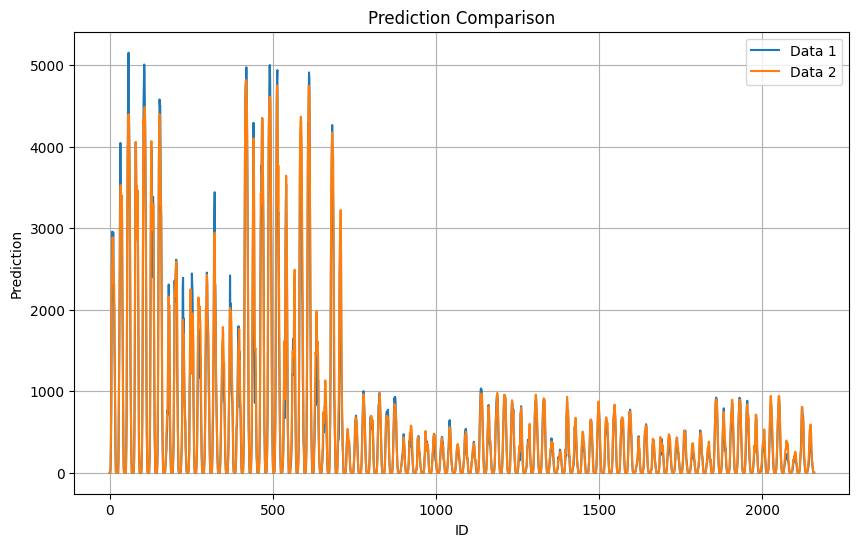

In [12]:
df1 = pd.read_csv("predictions_v16.csv")
df2 = pd.read_csv("predictions_v27.csv")

print(df1.columns)
print(df2.columns)

plt.figure(figsize=(10, 6))  # Set the size of the plot

plt.plot(df1['id'], df1['prediction'], label='Data 1', linestyle='-')
plt.plot(df2['id'], df2['predict'], label='Data 2', linestyle='-')

plt.xlabel('ID')
plt.ylabel('Prediction')
plt.title('Prediction Comparison')
plt.legend()

plt.grid(True)
plt.show()







In [7]:

x_test_a = model1.preprocessing_X_test(X_test_estimated_a)
x_test_a.to_csv('proc_test_data_a.csv')

x_test_b = model1.preprocessing_X_test(X_test_estimated_b)
x_test_b.to_csv('proc_test_data_b.csv')


x_test_c = model1.preprocessing_X_test(X_test_estimated_c)
x_test_c.to_csv('proc_test_data_c.csv')

In [8]:

x_test_a = model1.add_estimated_flag(X_test_estimated_a, True)
x_test_a = model1.preprocessing_X_test(x_test_a)
x_test_a.to_csv('proc_test_data_a.csv')

x_test_b = model1.add_estimated_flag(X_test_estimated_b, True)
x_test_b = model1.preprocessing_X_test(x_test_b)
x_test_b.to_csv('proc_test_data_b.csv')

x_test_c = model1.add_estimated_flag(X_test_estimated_c, True)
x_test_c = model1.preprocessing_X_test(x_test_c)
x_test_c.to_csv('proc_test_data_c.csv')

h2o.init()
model_a1 = h2o.upload_model(my_local_model_all1)
#model = h2o.get_model(model_a)




est_test_a = h2o.H2OFrame(x_test_a)

preds_a1 = model_a1.predict(est_test_a)
preds_df_a1 = preds_a1.as_data_frame()



model_b1 = h2o.upload_model(my_local_model_all1)

#model = h2o.get_model(model_b)



est_test_b = h2o.H2OFrame(x_test_b)

preds_b1 = model_b1.predict(est_test_b)
preds_df_b1 = preds_b1.as_data_frame()


model_c1 = h2o.upload_model(my_local_model_all1)

#model = h2o.get_model(model_c)



est_test_c = h2o.H2OFrame(x_test_c)

preds_c1 = model_c1.predict(est_test_c)
preds_df_c1 = preds_c1.as_data_frame()






Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmptl5ml0eq
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmptl5ml0eq/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmptl5ml0eq/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_olelasson_9xtwf1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [9]:



# Calculate mean for group A
preds_df_a1.rename(columns={'predict': 'prediction'}, inplace=True)
preds_df_a1['prediction'] = preds_df_a1['prediction'].apply(lambda x: 0.0 if x < 5 else x)

# Calculate mean for group B
preds_df_b1.rename(columns={'predict': 'prediction'}, inplace=True)
preds_df_b1['prediction'] = preds_df_b1['prediction'].apply(lambda x: 0.0 if x < 5 else x)


# Calculate mean for group C
preds_df_c1.rename(columns={'predict': 'prediction'}, inplace=True)
preds_df_c1['prediction'] = preds_df_c1['prediction'].apply(lambda x: 0.0 if x < 5 else x)



# Combine DataFrames
final_df = pd.concat([preds_df_a1, preds_df_b1, preds_df_c1], axis=0, ignore_index=True)

# Set the index name to 'id'
final_df.index.name = 'id'

# Save to a CSV file
final_df.to_csv('predictions_v43_feateng_longtraining.csv')


### Comperable prediction

In [10]:
file2 = 'predictions_v32_45min_old_model.csv'
file1 = 'predictions_v43_feateng_longtraining.csv'

In [11]:
def create_comperable_prediction_csv(prediction_name):
    postproc_A = model1.preprocessing_X_test(X_test_estimated_a)
    postproc_B = model1.preprocessing_X_test(X_test_estimated_b)
    postproc_C = model1.preprocessing_X_test(X_test_estimated_c)

    postproc_A = postproc_A.reset_index()
    postproc_B = postproc_B.reset_index()
    postproc_C = postproc_C.reset_index()

    time_A = postproc_A['time']
    time_B = postproc_B['time']
    time_C = postproc_C['time']

    all_times = pd.concat([time_A, time_B, time_C], ignore_index=True)

    predictions = pd.read_csv(prediction_name)

    if len(all_times) == len(predictions):
        predictions['time'] = all_times
    else:
        raise ValueError("The concatenated 'time' column does not match the size of the predictions dataframe.")
    if 'id' in predictions.columns:
        predictions.drop(columns=['id'], axis=1, inplace=True)
    if ' id' in predictions.columns:
        predictions.drop(columns=[' id'], axis=1, inplace=True)
    

    predictions.to_csv(f'comperable_{prediction_name}')

create_comperable_prediction_csv(file1)
create_comperable_prediction_csv(file2)

In [12]:
# Load the CSV files
predictions_vX = pd.read_csv(f'comperable_{file1}')
predictions_vY = pd.read_csv(f'comperable_{file2}')


In [13]:
import seaborn as sns

# Convert the time column to datetime format for better plotting
predictions_vX['time'] = pd.to_datetime(predictions_vX['time'])
predictions_vY['time'] = pd.to_datetime(predictions_vY['time'])


# Extract day and hour information from the 'time' column
predictions_vY['day'] = predictions_vX['time'].dt.date
predictions_vX['hour'] = predictions_vX['time'].dt.hour

diff_vX_vY = (predictions_vX['prediction'] - predictions_vY['prediction']).abs()

# Compute the absolute difference for each timestamp
predictions_vX['diff'] = diff_vX_vY

third_length = len(predictions_vX) // 3

# Split the datasets for each location
locations = {
    "Location A": (0, third_length),
    "Location B": (third_length, 2 * third_length),
    "Location C": (2 * third_length, len(predictions_vX))
}

### Heatmap

In [14]:
# Plot heatmaps for each location
plt.figure(figsize=(15, 15))

for idx, (location, (start, end)) in enumerate(locations.items(), 1):
    # Pivot the data to get differences in a matrix form suitable for heatmap
    heatmap_data = predictions_vX[start:end].pivot("day", "hour", "diff")
    
    plt.subplot(3, 1, idx)
    sns.heatmap(heatmap_data, cmap="YlOrRd", cbar_kws={'label': 'Difference'})
    
    plt.title(f"Heatmap of Prediction Differences for {location}")
    plt.ylabel("Day")
    plt.xlabel("Hour of Day")

plt.tight_layout()
plt.show()

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

<Figure size 1500x1500 with 0 Axes>

### Diff Plot

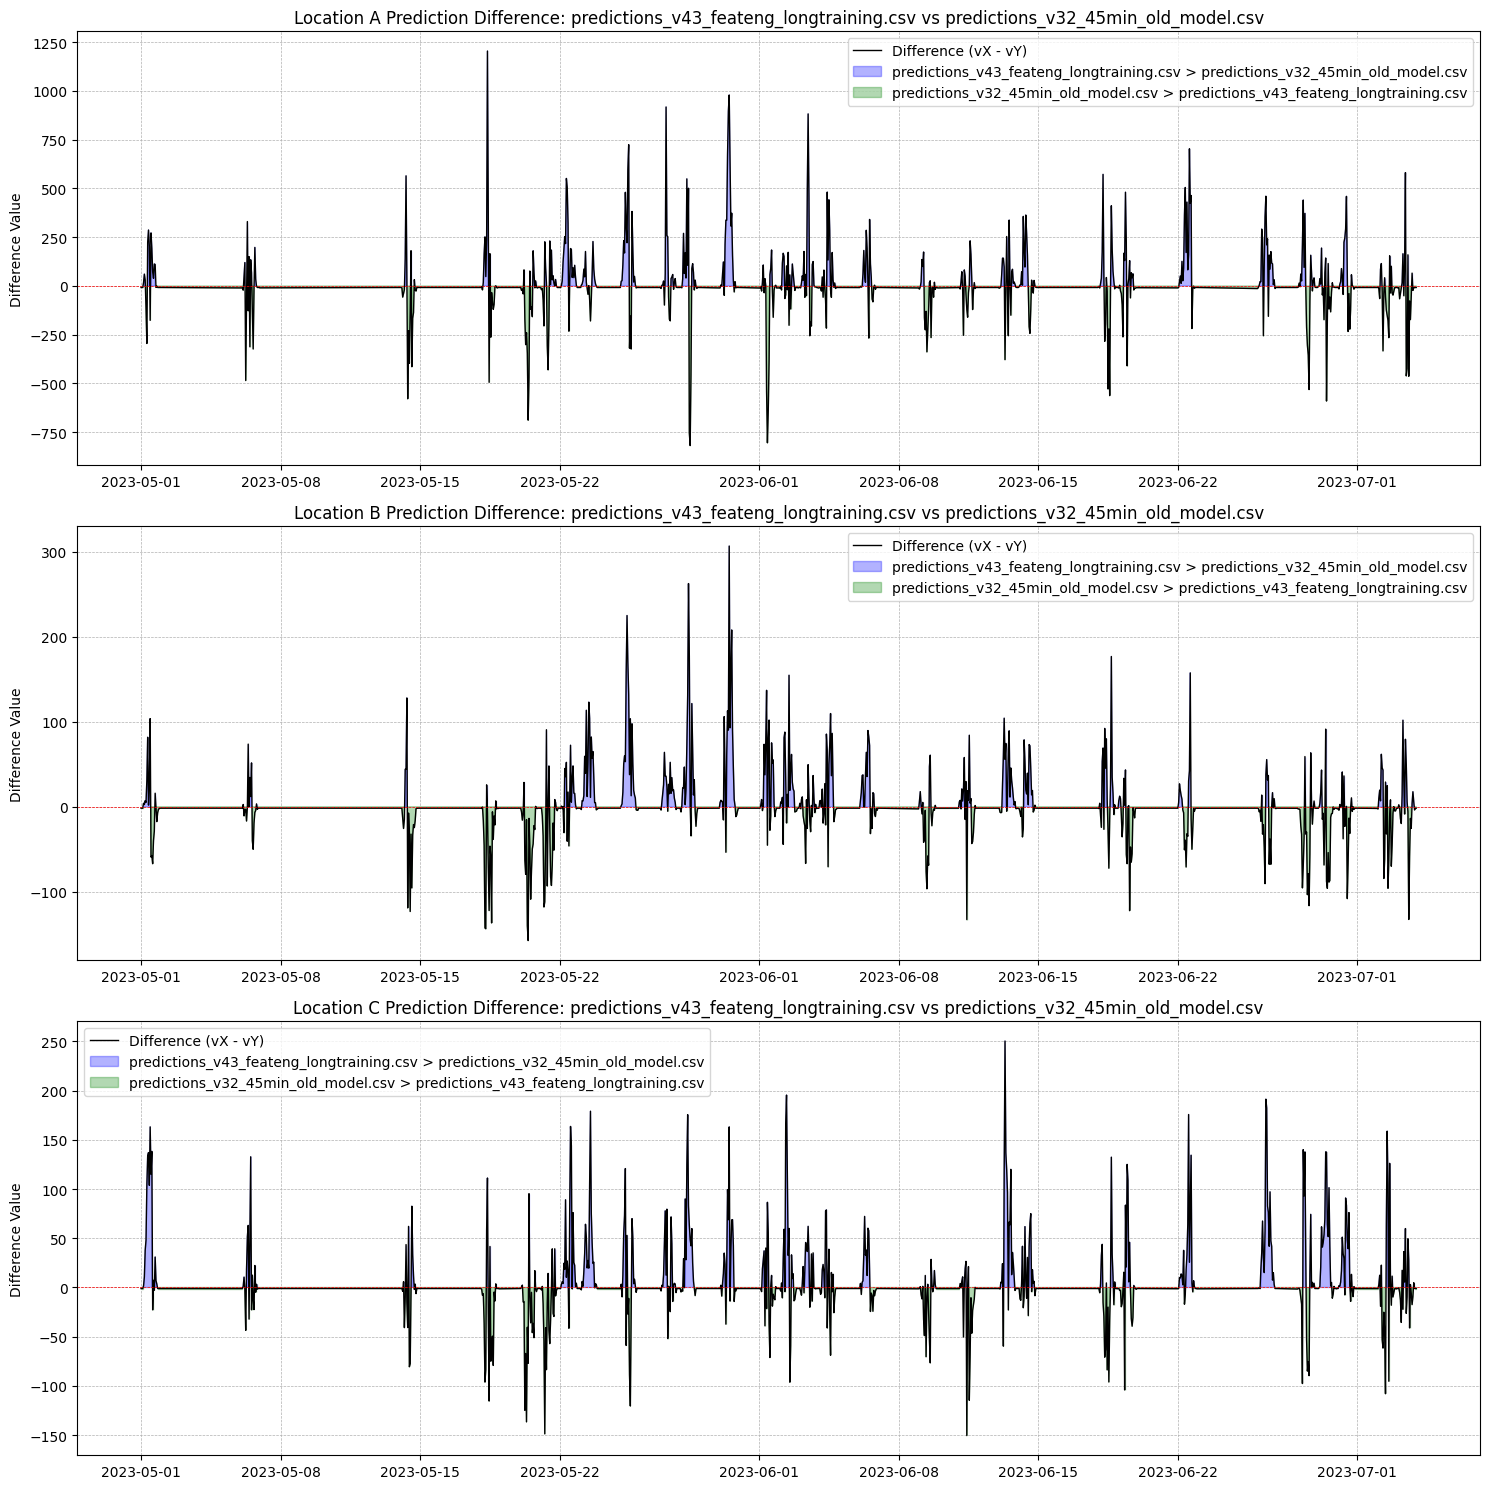

In [14]:
# Calculate the split index for each location based on the total number of rows
split_index = len(predictions_vX) // 3

# Split the datasets for each location
predictions_vX_A = predictions_vX.iloc[:split_index]
predictions_vX_B = predictions_vX.iloc[split_index:2*split_index]
predictions_vX_C = predictions_vX.iloc[2*split_index:]

predictions_vY_A = predictions_vY.iloc[:split_index]
predictions_vY_B = predictions_vY.iloc[split_index:2*split_index]
predictions_vY_C = predictions_vY.iloc[2*split_index:]

def filter_zero_intervals(df1, df2):
    """Filter out continuous zero intervals from both dataframes."""
    # Identify rows where both versions have zero predictions
    zero_mask = (df1['prediction'] == 0) & (df2['prediction'] == 0)
    
    # Filter out these rows
    return df1[~zero_mask], df2[~zero_mask]

def plot_difference(df1, df2, title):
    """Plot the difference between two dataframes' predictions."""
    diff = df1['prediction'] - df2['prediction']
    
    plt.plot(df1['time'], diff, label="Difference (vX - vY)", color="black", linewidth=1)
    
    # Highlight areas where Version X is greater than Version Y
    plt.fill_between(df1['time'], diff, where=(diff > 0), color='blue', alpha=0.3, label=f"{file1} > {file2}")
    
    # Highlight areas where Version Y is greater than Version X
    plt.fill_between(df1['time'], diff, where=(diff < 0), color='green', alpha=0.3, label=f"{file2} > {file1}")
    
    plt.axhline(0, color='red', linestyle="--", linewidth=0.5)
    plt.title(title)
    plt.ylabel("Difference Value")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Filter out zero intervals for each location
predictions_vX_A, predictions_vY_A = filter_zero_intervals(predictions_vX_A, predictions_vY_A)
predictions_vX_B, predictions_vY_B = filter_zero_intervals(predictions_vX_B, predictions_vY_B)
predictions_vX_C, predictions_vY_C = filter_zero_intervals(predictions_vX_C, predictions_vY_C)

# Set up the plots
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Plot the difference for each location
plt.sca(ax[0])
plot_difference(predictions_vX_A, predictions_vY_A, f"Location A Prediction Difference: {file1} vs {file2}")

plt.sca(ax[1])
plot_difference(predictions_vX_B, predictions_vY_B, f"Location B Prediction Difference: {file1} vs {file2}")

plt.sca(ax[2])
plot_difference(predictions_vX_C, predictions_vY_C, f"Location C Prediction Difference: {file1} vs {file2}")

plt.tight_layout()
plt.show()

In [ ]:
data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

final = pd.DataFrame()

final['prediction'] = (data1['prediction'] + data2['prediction']) / 2
final['prediction'] = final['prediction'].apply(lambda x: 0.0 if x < 5 else x)


final.index.name = 'id'

final.to_csv('predictions_v34_average_long&best_v32&16.csv')


In [21]:
final = pd.read_csv('predictions_v38_summer.csv')

final['prediction'] = final['prediction'].apply(lambda x: 0.0 if x < 5 else x)

final.drop(columns='id', axis=1, inplace=True)

final.index.name = 'id'

final.to_csv('predictions_v39_summer&cut5.csv')

,time,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,week,month,loc_flag,average_measurement,Unnamed: 0,prediction
0,2023-05-01 00:00:00,4.325,1.28675,912.7000,0.000,0.000,1061.5500,0.0,271.65002,0.000,...,2.100,3.35,0.0,0.0,18.0,5.0,-1,0.000000,0,0.000000
1,2023-05-01 01:00:00,4.275,1.28600,1482.1000,0.000,0.000,1075.1001,0.0,271.45000,0.000,...,1.925,3.30,0.0,1.0,18.0,5.0,-1,0.000000,1,0.000000
2,2023-05-01 02:00:00,4.150,1.28375,1791.3000,0.000,0.000,1200.4000,0.0,271.05000,0.000,...,1.750,3.20,0.0,2.0,18.0,5.0,-1,1.833333,2,0.000000
3,2023-05-01 03:00:00,4.025,1.28200,2312.8750,10124.425,11.675,1179.8500,0.0,270.65000,9.375,...,1.450,3.15,0.0,3.0,18.0,5.0,-1,85.621905,3,62.557304
4,2023-05-01 04:00:00,3.900,1.28100,2198.2998,141748.600,76.875,920.0500,0.0,270.37500,47.400,...,1.300,3.05,0.0,4.0,18.0,5.0,-1,350.397143,4,318.935867


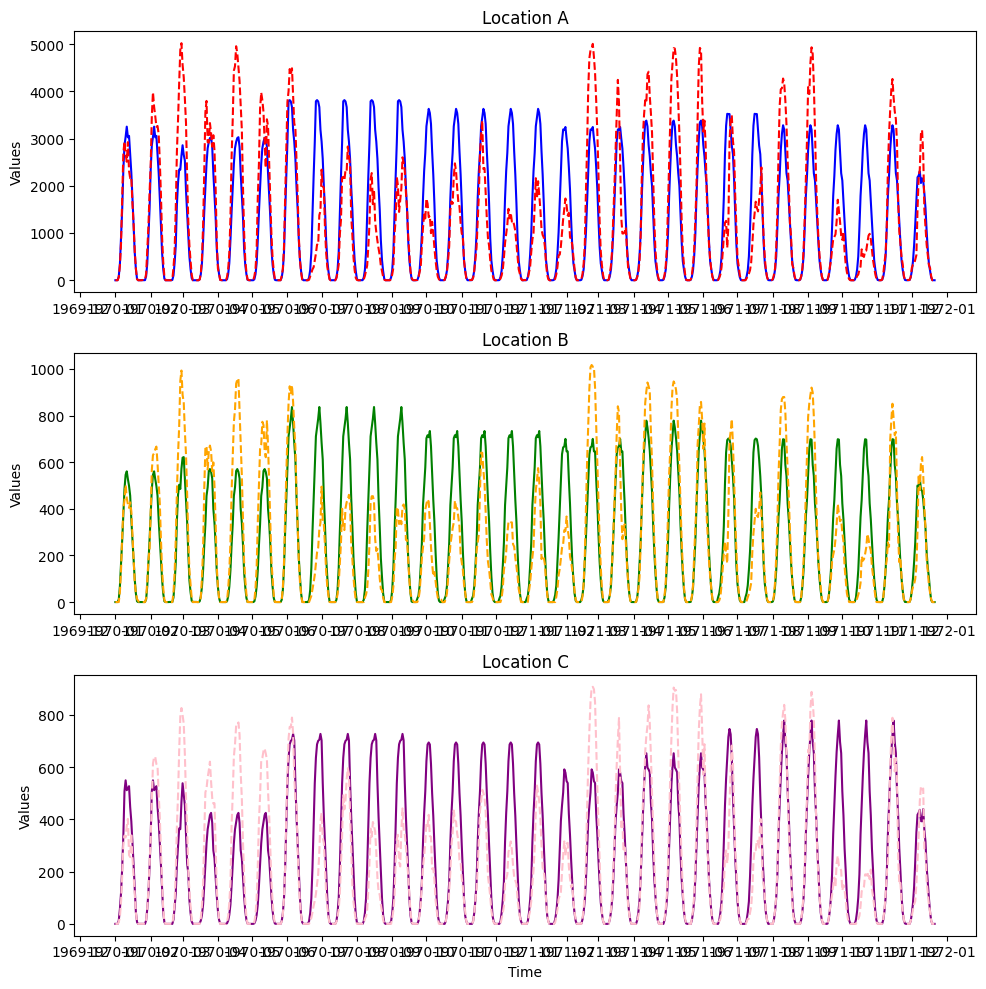

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate the split index for each location based on the total number of rows
split_index = len(predictions_vX) // 3

df = pd.read_csv('comperable_predictions_v34_average_long&best_v32&16.csv')

a_data = pd.read_csv('proc_test_data_a.csv')
b_data = pd.read_csv('proc_test_data_b.csv')
c_data = pd.read_csv('proc_test_data_c.csv')

# Split the datasets for each location
a = df.iloc[:split_index]
b = df.iloc[split_index:2 * split_index]
c = df.iloc[2 * split_index:]

a_combined = a_data.merge(a, how='inner', on='time')
b_combined = b_data.merge(b, how='inner', on='time')
c_combined = c_data.merge(c, how='inner', on='time')

# Set up the figure and axes
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Customize the plot for location A
axs[0].plot(a_combined['time'], a_combined['average_measurement'], label='Actual A', linestyle='-', color='blue')
axs[0].plot(a_combined['time'], a_combined['prediction'], label='Prediction A', linestyle='--', color='red')
axs[0].set_ylabel('Values')
axs[0].set_title('Location A')
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show x-axis labels for each month
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the x-axis labels as 'YYYY-MM'

# Customize the plot for location B
axs[1].plot(b_combined['time'], b_combined['average_measurement'], label='Actual B', linestyle='-', color='green')
axs[1].plot(b_combined['time'], b_combined['prediction'], label='Prediction B', linestyle='--', color='orange')
axs[1].set_ylabel('Values')
axs[1].set_title('Location B')
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Customize the plot for location C
axs[2].plot(c_combined['time'], c_combined['average_measurement'], label='Actual C', linestyle='-', color='purple')
axs[2].plot(c_combined['time'], c_combined['prediction'], label='Prediction C', linestyle='--', color='pink')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Values')
axs[2].set_title('Location C')
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Show the plots
plt.tight_layout()


a_combined.head()
